# Notebook: historical RAG EN
This notebook contains the code for building an english dataset to evaluate the RAG model for historical research.

# 0. Install libraries

In [ ]:
!pip install -qU openai cohere faiss-cpu langchain langchain-community tiktoken==0.5.2 langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.5/814.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.4/278.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Create a vectorstore
A vector store is neccessary for the retrieval part of the model. This consists of text parts from the fed-in sources and later serves as a knowledge base for the retriever.

In [ ]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the next step, an embedding model is initiated (here: `text-embedding-ada-002` from [OpenAI](https://openai.com/blog/new-and-improved-embedding-model)).

In [ ]:
# setup embedding model
import os
from getpass import getpass
from langchain_openai import OpenAIEmbeddings

secret = getpass("Enter your OpenAI API key: ")
OPENAI_API_KEY = secret
model_name = 'text-embedding-ada-002'

embeddings = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

## Build index
The index is build with a subsample of the orginial 9238 chunks.

In [ ]:
# path to folder containing the .txt files
folder_path = "../data/source_documents_TXT"

# Key: file name, Value: file content
data = {}

# iterate through all files
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        data[file_name] = file.read()

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size = 1000, chunk_overlap=200, separator='')

In [ ]:
# build the docs from the file dict
docs = []

# lists for texts and their corresponding metadata
texts = []
metadatas = []

# iterate over each file and its content in the data dict
for file_name, text_content in data.items():
    # add content
    texts.append(text_content)
    # create a metadata dict and add it
    metadatas.append({'filename': file_name})

# create docs
docs = text_splitter.create_documents(texts, metadatas)

In [ ]:
# calculate num of chars to calculate costs
def calculate_characters(docs):
    total_characters = sum(len(doc.page_content) for doc in docs)
    return total_characters

characters = calculate_characters(docs)

print(f"Total number of characters in all documents: {characters}")

Total number of characters in all documents: 9201037


In [ ]:
# take random subsample
import random

sample = random.sample(docs, 500)

In [ ]:
def calculate_characters(docs):
    total_characters = sum(len(doc.page_content) for doc in docs)
    return total_characters

characters = calculate_characters(sample)

print(f"Total number of characters in sample documents: {characters}")

Total number of characters in sample documents: 467721


In [ ]:
# set subsample as docs
docs = sample

In [ ]:
import deepl

secret_deepl = getpass("Enter your DeepL API key: ")
auth_key=secret_deepl
translator = deepl.Translator(auth_key)

def translate(text, target_language="EN-GB"):
    try:
        result = translator.translate_text(text, target_lang=target_language)
        return result.text
    except Exception as e:
        print(f"An error occurred: {e}")
        return "Translation error"

In [ ]:
# test
result = translator.translate_text("Wie geht es dir?!", target_lang="EN-GB")
print(result.text)

How are you?!


In [ ]:
# apply translation function
for doc in docs:
    doc.page_content = translate(doc.page_content,"EN-GB")

In [ ]:
# did it work?
print(docs[3], '\n', docs[7])

page_content='lassenheit der Zukunft gegenüber.\n\nDas trifft den einen weniger, die anderen mehr und viele mit der ganzen furchtbaren Wucht. In einem seid ihr aber alle reich geworden: reich an Sorge. O diese große tägliche und nächtliche Sorge bei so großer Armut!\n\nDer Grund\n\nIch stocke wieder. Ich blicke zu meinen Kameraden hinüber, ihre behelmten Stirnen scheinen mir nicht zuzunicken, die starken Augen unter dem Helmrand scheinen zu sagen: Vergiss das Beste nicht, Kamerad!\n\nWollt ihr mir folgen, ihr Frauen und Mädchen, zu dem was wir das Beste nennen, auf den Grund, auf den tiefsten Grund hinunter? Wenn ihr ein Korn in die Erde sät, was ist es doch für ein armes Korn in der großen, fremden Erde! Das ganz Andere umgibt es und deckt es zu. Ist es nicht dem Vergehen ausgesetzt? Aber das kleine Korn ist ganz gesammelt in sich, es hat nur sich selbst, es birgt etwas, birgt den zartesten Lebensfunken in seiner spröden Schale. Es birgt das Beste der oberen Welt zurückgezogen in sich

**Note**: The CharacterTextSplitter is a very simple type of splitting. Other options are:
- SemanticChunker:
  https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker
- ParentDocument retriever: https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever; https://www.youtube.com/watch?v=07H-om5lj-s&t=131s


Using the embedding model, the individual chunks are converted into embeddings and loaded into a [FAISS](https://faiss.ai/index.html) store using [LangChain](https://python.langchain.com/docs/integrations/vectorstores/faiss).

In [ ]:
# setup FAISS store
from langchain.vectorstores import FAISS

# storing embeddings in the vector store
vectorstore = FAISS.from_documents(docs, embeddings)

## Querying
To test whether the vector store is working properly, we run a test with the question "Was will Friederike mit ihrer Freundin Gudrun machen?" (What does Friederike want to do with her friend Gudrun?). Both are characters from the "Menschenwende" novel published by Frauen-Warte in 1935.

In [ ]:
query = "What does Friederike want to do with her friend Gudrun?"

vectorstore.similarity_search(
    query,
    k=3
)

[Document(page_content='so it will be war again, he is grown up, and he will be shot to death. Freestyle. Germany. Yes, I would have to give him up, ten more sons if I had them. They wouldn\'t even ask me. About the heart; breaks. If it is a girl, she will turn away from me to her father, of course he is much kinder than I am, and I shall be unfit to bring her up, and she will crush my heart too." Gudrun asked why she didn\'t move into this lovely flat? "Yes, perhaps I could do it now," she replied, "now that you have slept in his bed. I can\'t very well put up a second one, the room would be all spoilt. But if I keep house here, I must live entirely on his money." "I wouldn\'t worry the least about that money," said Gudrun. "When there is so much. You\'ll have to use it for the child anyway. You must prepare a home for him." Gudrun woke up in the night. A light was burning in the next room.', metadata={'filename': '1935_36_11.txt'}),
 Document(page_content='The reception in the castle

# 2. Build the RAG model
The RAG model will be built next.

First, the vectorstore created above is initialised as a retriever.

To include the dialogue story in the chat, a prompt template is defined and converted into a `PromptTemplate` object. In this template, the dialogue history is merged with the current question.

In [ ]:
from langchain.prompts.prompt import PromptTemplate

retriever = vectorstore.as_retriever()

_template = """Rephrase the following dialogue and the follow-up question so that it is an independent question, in the original language.

Dialogue history:
{chat_history}
follow-up question: {question}
independent question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In a further prompt, the context (the documents retrieved from the KB) is summarised in an instruction with the query in order to be transferred together to the LLM, that gives the final answer.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based solely on the following context:
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

For the `context` variable, we need the content of the retrieved documents as text. To do this, we write a function that takes the documents, a template to get the `page_content` and a separator and returns the joined texts.

In [ ]:
from langchain.schema import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

### Now we put the chain together (fist with an empty `chat_history`).
Docs for the used Runnables:
- [RunnableParallel](https://python.langchain.com/docs/expression_language/how_to/map)
- [RunnablePassthrough](https://python.langchain.com/docs/expression_language/how_to/passthrough)

**1. Integrate the dialog history with `_inputs`:**  
- `RunnableParallel()` manipulates the output so that it fits as input into the next runnable of the sequence (here: `CONDENSE_QUESTION_PROMPT`)
- `RunnablePassthrough()` is used to pass the `chat_history` to the input as a further argument
- the `CONDENSE_QUESTION_PROMPT` applies the template defined above
- this is sent to `ChatOpenAI()`
- the output is formatted as a string with `StrOutputParser()`

**2. Build `_context` from:**
1. The documents that are found with the retriever. The search input for this is the `standalone_question`.
> `itemgetter` is a shorthand to extract data from the map (see [Python Docu](https://docs.python.org/3/library/operator.html#operator.itemgetter)).
2. And `question`, which was converted to the `standalone_question` together with the dialogue history.


**3. Put the `conversational_qa_chain` together from:**
- `_inputs`
- `_context`
- the `ANSWER_PROMPT` from above
- and the LLM to which all the information in this prompt is passed.


In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY)

We start the chain with a question and an initially empty chat history:

In [ ]:
conversational_qa_chain.invoke(
    {
        "question": "What does Friederike what do to with her friend Gudrun?",
        "chat_history": []
    }
)

AIMessage(content='Friederike wants to confide in her friend Gudrun about her struggles and feelings regarding her relationship with a man who is now deceased and the child she is carrying.', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 922, 'total_tokens': 958}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-14d1c34d-4d84-4149-aea9-d2ffab23b802-0')

Looks good! Now let's add the actual chat_history to the chain:

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)

In [ ]:
print(memory)

output_key='answer' input_key='question' return_messages=True


The final chain is assembled.
Docs for the runnables:
[RunnableLambda](https://python.langchain.com/docs/expression_language/how_to/functions)
1. We add one step to `loaded_memory` and add the **history**.
2. `standalone_question` is formed using the current `question` and `chat_history`, both sent to the LLM with the `CONDENSE_QUESTION_PROMPT`.
3. Retrieve the documents with the `standalone_question` and the retriever.
4. Assemble the inputs for the `ANSWER_PROMPT`.
5. Define the answer as the output of the LLM to the `ANSWER_PROMPT` plus the documents used.
6. Put everything together in a final chain.

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# 1. add memory
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)

# 2. calc the standalone_question
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
}

# 3. retrieve the docs
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}

# 4. put the final_inputs together
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}

# 5. define answer structure
answer = {
    "answer": final_inputs | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY),
    "docs": itemgetter("docs"),
}

# 6. put everything together
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

Let's test it

In [ ]:
inputs = {"question": "What does Friederike want to do with her friend Gudrun?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Friederike wants to confide in her friend Gudrun about her feelings and struggles, particularly regarding her past relationship and the child she is carrying.', response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 922, 'total_tokens': 954}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5c45f7f-f3a6-4cf3-a387-d1ea114e574c-0'),
 'docs': [Document(page_content='so it will be war again, he is grown up, and he will be shot to death. Freestyle. Germany. Yes, I would have to give him up, ten more sons if I had them. They wouldn\'t even ask me. About the heart; breaks. If it is a girl, she will turn away from me to her father, of course he is much kinder than I am, and I shall be unfit to bring her up, and she will crush my heart too." Gudrun asked why she didn\'t move into this lovely flat? "Yes, perhaps I could do it now," she replied, "now that you have slept in

### Note: memory is not needed for RAGAs ###

---
# 3. Evaluation with RAGAS
Tutorial: [AI Makerspace / YT ](https://www.youtube.com/watch?v=mEv-2Xnb_Wk)

Doku: [RAGAS Get started](https://docs.ragas.io/en/latest/getstarted/index.html)

- but: can't use template for automated dataset generation bc need to adjust the prompt (german)
- update `relevancy` / `precision`

## 3.1 Ground Truth dataset creation

In [ ]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

# set schema for the question
question_schema = ResponseSchema(
    name="question",
    description="a question about the context."
)

question_response_schemas = [
    question_schema,
]

In [ ]:
# tell parser to use the schema
question_output_parser = StructuredOutputParser.from_response_schemas(question_response_schemas)
format_instructions = question_output_parser.get_format_instructions()

In [ ]:
# set LLM
question_generation_llm = ChatOpenAI(model="gpt-3.5-turbo-16k", openai_api_key=OPENAI_API_KEY)

bare_prompt_template = "{content}"
bare_template = ChatPromptTemplate.from_template(template=bare_prompt_template)

In [ ]:
from langchain.prompts import ChatPromptTemplate

qa_template = """\
You are a history professor creating a test for advanced students. For each context, create a question that is specifically tailored to that context. Avoid asking generic or general questions.

question: a question about the context.

Format the output as JSON with the following keys:
question:

context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=docs[44], # format needed
    format_instructions=format_instructions
)

# chain bare_template with qa llm
question_generation_chain = bare_template | question_generation_llm

# test
response = question_generation_chain.invoke({"content" : messages}) # generate question
output_dict = question_output_parser.parse(response.content) # safe in dict

In [ ]:
for k, v in output_dict.items(): # example
  print(k)
  print(v)

question
What is the significance of the diary in the given context?
context
I sensed a secret that the priest was hiding. "Let's not go our separate ways; tell us what motivated this life." - "She'll tell you herself, and if it's tonight, I'll read you the parts of the book that matter." A woman went to fetch a lantern. We were silent until she returned. Then the priest opened the diary, which was densely covered with bookmarks.

"Aunt Minchen was twenty years old when she made the first entry in this book.

"1876, 5 March: Adalbert was at the ball and danced with me. I will never forget it.
20 April: He was with us on Sunday. We went for a walk with his parents. He poured his heart out to me, spoke only of his love for Elisabeth and said that I was the only friend he could tell everything to. My heart was trembling, but I didn't let myself realise anything. What a cruel fate!
10 October: I hadn't seen him for a long time, heard he was running a great business.' metadata={'filename': 

In [ ]:
  !pip install -q -U tqdm

In [ ]:
from tqdm import tqdm # progression bar

qac_triples = []

# use function for part of the docs
for text in tqdm(docs[40:55]): # set here the docs to be used for the dataset
  messages = prompt_template.format_messages(
      context=text,
      format_instructions=format_instructions
  )
  response = question_generation_chain.invoke({"content" : messages})
  try:
    output_dict = question_output_parser.parse(response.content)
  except Exception as e:
    continue
  output_dict["context"] = text
  qac_triples.append(output_dict)

100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


In [ ]:
print(qac_triples) # quick quality check of the dataset

[{'question': 'What did the woman invent to save time while welding?', 'context': Document(page_content="had to hold the workpiece. To free up both hands for welding, she devised a simple device that used a copper ring to hold the workpiece in place, freeing up the second hand. This idea saved 40% of the working time. [...]\nPage: 76\n\nZ?L?//1/75/)/^<7/? c/z/Z'c/e/) //o^^e/'^/c?^ ?The Women's Office of the German Labour Front has long campaigned for the regular release of working housewives from work in favour of their domestic duties. As a result of these efforts, and despite the heavy workload within the war economy, a good regulation has now been achieved with the order on the granting of the housework day, which came into force on 1 November 1943. Previously, it was at the discretion of the company managers to what extent they took into account the double burden of the working housewife. According to the new order, there is now a legal entitlement to the granting of the housework 

In [ ]:
# same for the answer: define chain and let llm produce the answers
answer_generation_llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0, openai_api_key=OPENAI_API_KEY)

answer_schema = ResponseSchema(
    name="answer",
    description="an answer to the question"
)

answer_response_schemas = [
    answer_schema,
]

answer_output_parser = StructuredOutputParser.from_response_schemas(answer_response_schemas)
format_instructions = answer_output_parser.get_format_instructions()

qa_template = """\
You are a history professor creating a test for advanced students. Create an answer for each question and context.

answer: an answer about the context.

Format the output as JSON with the following keys:
answer:

question: {question}
context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=qac_triples[0]["context"],
    question=qac_triples[0]["question"],
    format_instructions=format_instructions
)

answer_generation_chain = bare_template | answer_generation_llm

response = answer_generation_chain.invoke({"content" : messages})
output_dict = answer_output_parser.parse(response.content)

In [ ]:
for k, v in output_dict.items():
  print(k)
  print(v)

answer
The woman invented a simple device that used a copper ring to hold the workpiece in place for welding.
question
What did the woman invent to save time while welding?


In [ ]:
# apply answer llm
for triple in tqdm(qac_triples):
  messages = prompt_template.format_messages(
      context=triple["context"],
      question=triple["question"],
      format_instructions=format_instructions
  )
  response = answer_generation_chain.invoke({"content" : messages})
  try:
    output_dict = answer_output_parser.parse(response.content)
  except Exception as e:
    continue
  triple["answer"] = output_dict["answer"]

100%|██████████| 13/13 [02:09<00:00,  9.97s/it]


In [ ]:
!pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import Dataset

# generate df from dict
ground_truth_qac_set = pd.DataFrame(qac_triples)
ground_truth_qac_set["context"] = ground_truth_qac_set["context"].map(lambda x: str(x.page_content))
ground_truth_qac_set = ground_truth_qac_set.rename(columns={"answer" : "ground_truth"})

# to dataset
eval_dataset = Dataset.from_pandas(ground_truth_qac_set)

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'metadata', 'ground_truth'],
    num_rows: 13
})

In [ ]:
eval_dataset[1]

{'question': 'Who is the poet that wrote the poem described in the context?',
 'context': "poets, and you have to guess who wrote these poems. To make it easier, you will find the syllables of the poets' names and the pictures of the poets here. Also read the captions, which may give you some clues to help you find the right poet for each poem. The solution should be sent on a postcard to the editorial office of N.S. Frauen-Warte, Munich 22, Karolinenplatz 2, and labelled: 1st prize task: It may only contain the following information: the number of the poem, the number of the corresponding poet's picture and the poet's name, for example: poem 8, picture 10, Ludwig Uhland, poem 9, picture 15, Gottfried Keller etc. The syllables of the poets' names: ard - bal - bert - del - du - dur - - - flex - gang - goe - hann - h - i - jo - ke - men - mö - na - rach - ri - rg - schi - sei - ter - the - von - wal - wolf - - el. Please note that the poets' first names are also included in the pictures.

In [ ]:
eval_dataset.to_csv("../data/eval_datasets/groundtruth_eval_dataset_6_en.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

18301

## 3.2. Evaluating histoRAG

In [ ]:
from datasets import Dataset
eval_dataset = Dataset.from_csv("../data/eval_datasets/groundtruth_eval_dataset_6_en.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'metadata', 'ground_truth'],
    num_rows: 13
})

### Setup RAGAS

In [ ]:
!pip install -q ragas

In [ ]:
from ragas.metrics import ( # set metrics
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
    answer_correctness,
    answer_similarity
)
from ragas.metrics.critique import harmfulness
from ragas import evaluate

# to ragas dataset
def create_ragas_dataset(rag_pipeline, eval_dataset):
  rag_dataset = []
  for row in tqdm(eval_dataset):
    answer = rag_pipeline.invoke({"question" : row["question"]})
    rag_dataset.append(
        {"question" : row["question"],
         "answer" : answer["answer"].content,
         "contexts" : [doc.page_content for doc in answer["docs"]],
         "ground_truths" : [row["ground_truth"]]
         }
    )
  rag_df = pd.DataFrame(rag_dataset)
  rag_eval_dataset = Dataset.from_pandas(rag_df)
  return rag_eval_dataset

# set eval function
def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

In [ ]:
from tqdm import tqdm
import pandas as pd

basic_qa_ragas_dataset = create_ragas_dataset(final_chain, eval_dataset) # apply to final_chain

100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


In [ ]:
basic_qa_ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 13
})

In [ ]:
basic_qa_ragas_dataset[0]

{'question': 'What did the woman invent to save time while welding?',
 'answer': 'The woman invented a simple device that used a copper ring to hold the workpiece in place, freeing up her second hand for welding, which saved 40% of working time.',
 'contexts': ["had to hold the workpiece. To free up both hands for welding, she devised a simple device that used a copper ring to hold the workpiece in place, freeing up the second hand. This idea saved 40% of the working time. [...]\nPage: 76\n\nZ?L?//1/75/)/^<7/? c/z/Z'c/e/) //o^^e/'^/c?^ ?The Women's Office of the German Labour Front has long campaigned for the regular release of working housewives from work in favour of their domestic duties. As a result of these efforts, and despite the heavy workload within the war economy, a good regulation has now been achieved with the order on the granting of the housework day, which came into force on 1 November 1943. Previously, it was at the discretion of the company managers to what extent the

In [ ]:
basic_qa_ragas_dataset.to_csv("../data/eval_datasets/basic_qa_ragas_dataset_6_en.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

57783

### evaluate

In [ ]:
os.environ["OPENAI_API_KEY"] = secret

In [ ]:
basic_qa_result = evaluate_ragas_dataset(basic_qa_ragas_dataset)

Evaluating:   0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
basic_qa_result

{'context_precision': 0.7051, 'faithfulness': 1.0000, 'answer_relevancy': 0.9414, 'context_recall': 0.6117, 'context_relevancy': 0.0584, 'answer_correctness': 0.6032, 'answer_similarity': 0.9219}

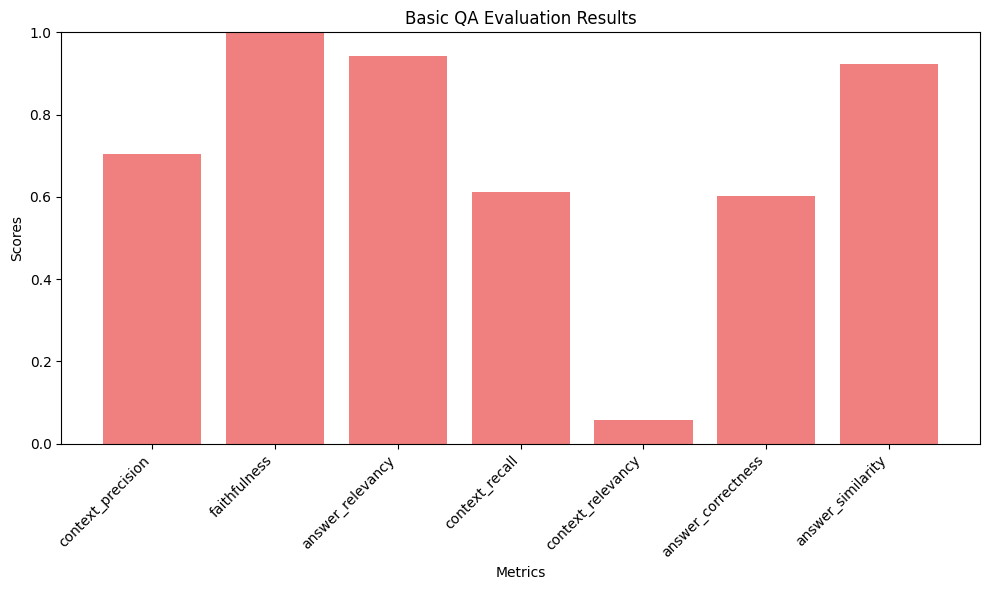

In [ ]:
# plot the result
import matplotlib.pyplot as plt

metrics = list(basic_qa_result.keys())
values = list(basic_qa_result.values())

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='lightcoral')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Basic QA Evaluation Results')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig('../data/plots/ragas_eval_6_en.png')
plt.show()